In [2]:
import numpy as np
import random

from gym import spaces

class RelOvergenEnv:

    def __init__(self, state_dim, n_agents=2,
                 optim_reward=12, optim_diff_coeff=30, 
                 suboptim_reward=0, suboptim_diff_coeff=0.08,
                 save_visited_states=False):
        self.obs_dim = state_dim
        self.act_dim = 3
        self.n_agents = n_agents

        self.state_dim = state_dim
        self.unit = 10.0 / state_dim
        self.states = list(np.arange(0.0, 10.0, self.unit))

        self._obs_high = np.ones(state_dim, dtype=np.float32)
        self._obs_low = np.zeros(state_dim, dtype=np.float32)
        self.observation_space = [
            spaces.Box(self._obs_low, self._obs_high) 
            for a_i in range(self.n_agents)]
        self._shared_obs_high = np.ones(
            state_dim * self.n_agents, dtype=np.float32)
        self._shared_obs_low = np.zeros(
            state_dim * self.n_agents, dtype=np.float32)
        self.shared_observation_space = [
            spaces.Box(self._shared_obs_low, self._shared_obs_high) 
            for a_i in range(self.n_agents)]
        self.action_space = [
            spaces.Discrete(3) for a_i in range(self.n_agents)]

        self.agents_pos = np.zeros(self.n_agents, dtype=np.int8)
        # [0, 0]

        self.optimal_state = [
            int(state_dim / 4) * self.unit, 
            int(state_dim / 5) * self.unit, 
            int(state_dim / 6) * self.unit, 
            int(state_dim / 5) * self.unit, 
            int(state_dim / 4) * self.unit]
        self.suboptimal_state = [
            10.0 - self.optimal_state[a_i] for a_i in range(self.n_agents)]
        
        self.optim_reward = optim_reward
        self.optim_diff_coeff = optim_diff_coeff
        self.suboptim_reward = suboptim_reward
        self.suboptim_diff_coeff = suboptim_diff_coeff
        
        self.max_steps = state_dim
        self.current_step = 0

        self.save_visited = save_visited_states
        self.visited_states = []

    def get_obs(self):
        if self.save_visited:
            self.visited_states.append(list(self.agents_pos))
        return [np.eye(self.state_dim)[self.agents_pos[a_i]] 
                for a_i in range(self.n_agents)]

    def reset(self, init_pos=None):
        for a_i in range(self.n_agents):
            self.agents_pos[a_i] = random.randint(0, self.state_dim - 1)
        self.current_step = 0
        return self.get_obs()

    def compute_reward(self):
        opti = self.optim_reward - self.optim_diff_coeff * sum([
            (self.states[self.agents_pos[a_i]] - self.optimal_state[a_i]) ** 2
            for a_i in range(self.n_agents)])
        subopti = self.suboptim_reward - self.suboptim_diff_coeff * sum([
            (self.states[self.agents_pos[a_i]] - self.suboptimal_state[a_i]) ** 2
            for a_i in range(self.n_agents)])
        return max(opti, subopti)

    def step(self, actions):
        for a_i in range(self.n_agents):
            onehot_action = np.eye(3)[int(actions[a_i][0])]
            if self.agents_pos[a_i] < self.state_dim - 1:
                self.agents_pos[a_i] += int(onehot_action[0])
            if self.agents_pos[a_i] > 0:
                self.agents_pos[a_i] -= int(onehot_action[1])
        next_states = self.get_obs()

        reward = self.compute_reward()
        rewards = [reward] * self.n_agents
        
        self.current_step += 1
        done = float(self.current_step >= self.max_steps)
        dones = [done] * self.n_agents
        
        return next_states, rewards, dones, None

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def close(self):
        pass

# Plotting the reward function

## 2D

In [2]:
def get_2D_reward_function(env):
    reward = np.zeros((env.state_dim, env.state_dim))
    for i in range(env.state_dim):
        for j in range(env.state_dim):
            env.agents_pos = [i, j]
            reward[i, j] = env.compute_reward()
    return reward

<Axes: >

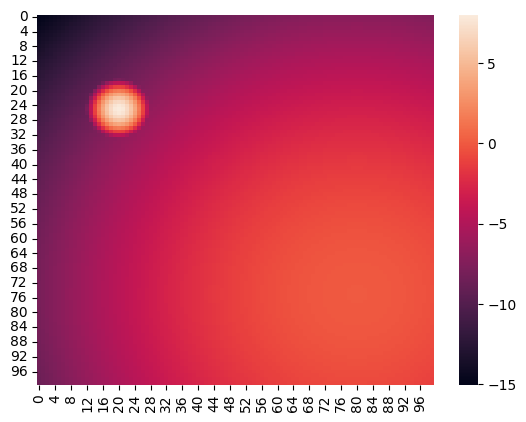

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

env = RelOvergenEnv(
    state_dim=100, 
    n_agents=2, 
    optim_reward=8, 
    optim_diff_coeff=25, 
    suboptim_reward=0, 
    suboptim_diff_coeff=0.125)
reward = get_2D_reward_function(env)
sns.heatmap(reward)

<Axes: >

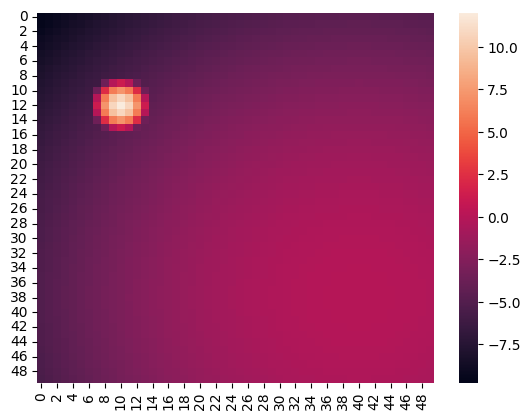

In [5]:
env = RelOvergenEnv(
    state_dim=50, 
    n_agents=2, 
    optim_reward=12, 
    optim_diff_coeff=30, 
    suboptim_reward=0, 
    suboptim_diff_coeff=0.08)
reward = get_2D_reward_function(env)
sns.heatmap(reward)

<Axes: >

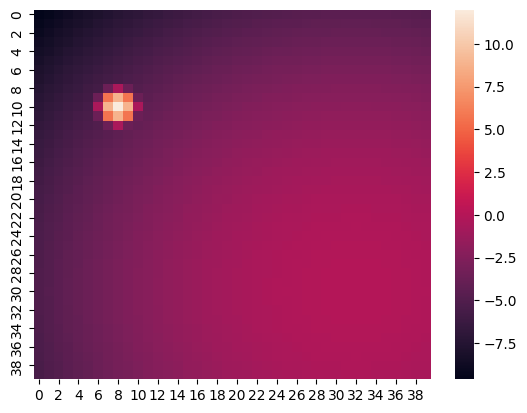

In [6]:
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=2, 
    optim_diff_coeff=50)
reward = get_2D_reward_function(env)
sns.heatmap(reward)

### Save to .jpg

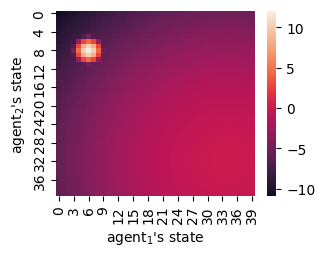

In [6]:
import matplotlib.pyplot as plt
env = RelOvergenEnv(40, 12, 30, 0, 0.08)
reward = get_reward_function(env)
fig, ax = plt.subplots(figsize=(3.2,2.4))  
s = sns.heatmap(reward, center=0, cmap=sns.cm.rocket, ax=ax)
s.set(xlabel=r"agent$_1$'s state", ylabel=r"agent$_2$'s state")
plt.savefig("ro_map.jpg", dpi=500, bbox_inches='tight')

## Surface plot

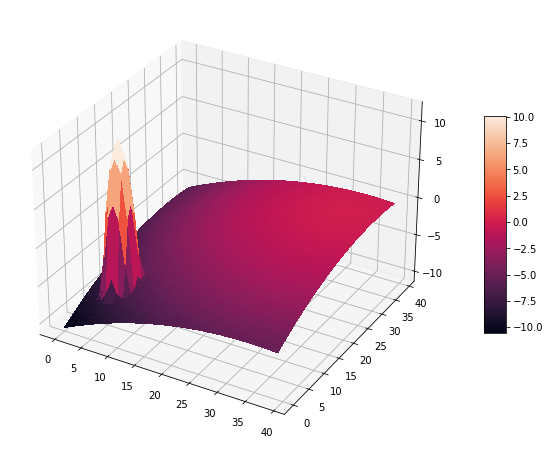

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(15, 8))
X = np.arange(0, 40, 1)
Y = np.arange(0, 40, 1)
X, Y = np.meshgrid(X, Y)
hm = ax.plot_surface(X, Y, reward, cmap=sns.cm.rocket, antialiased=False)
fig.colorbar(hm, shrink=0.5, aspect=10)

## 3D

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_3D_reward_function(env):
    reward = np.zeros((env.state_dim, env.state_dim, env.state_dim))
    for i in range(env.state_dim):
        for j in range(env.state_dim):
            for k in range(env.state_dim):
                env.agents_pos = [i, j, k]
                reward[i, j, k] = env.compute_reward()
    return reward

z = 0


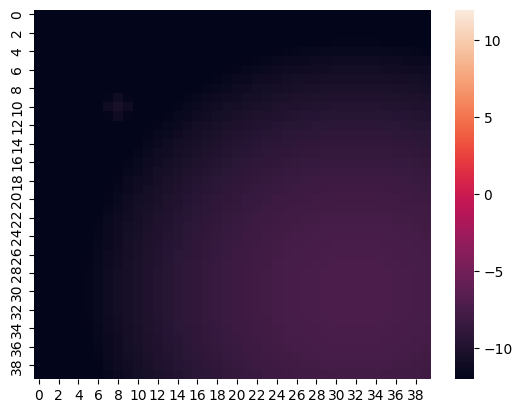

z = 1


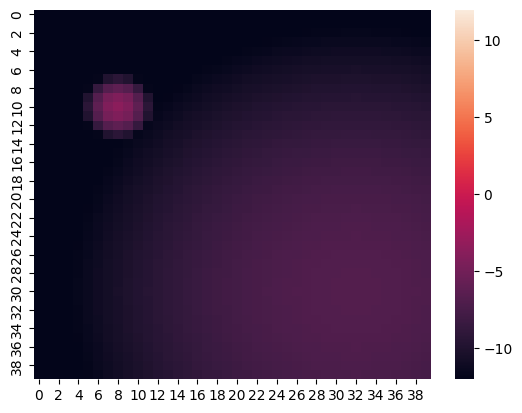

z = 2


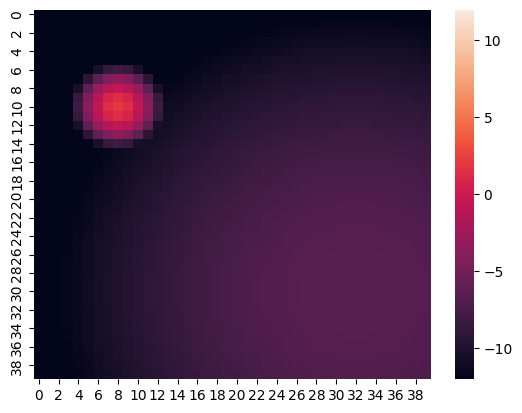

z = 3


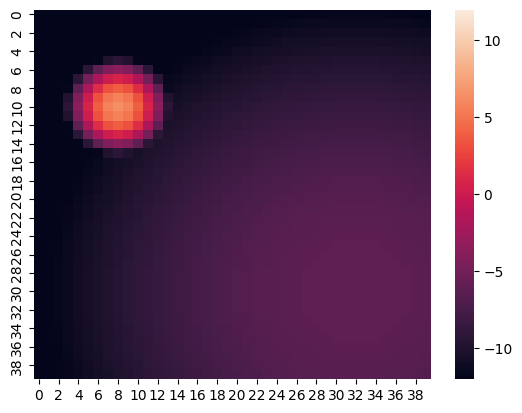

z = 4


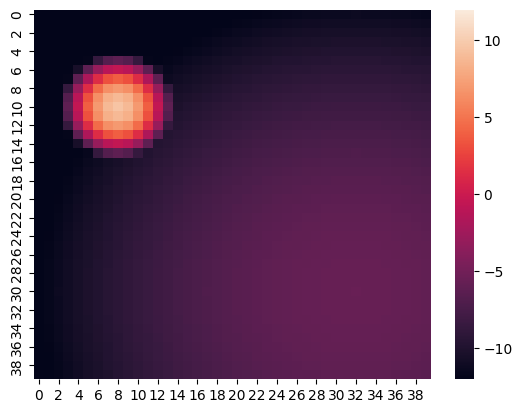

z = 5


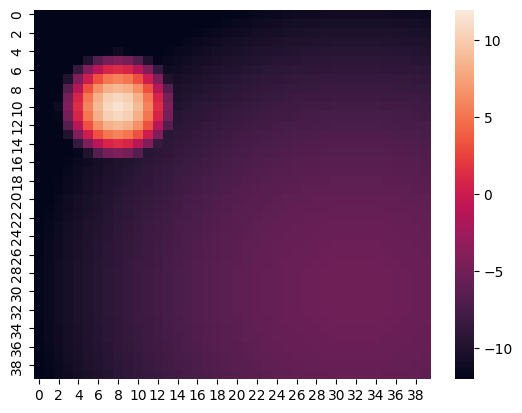

z = 6


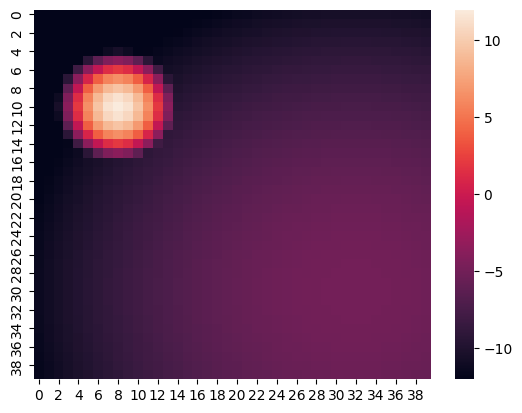

z = 7


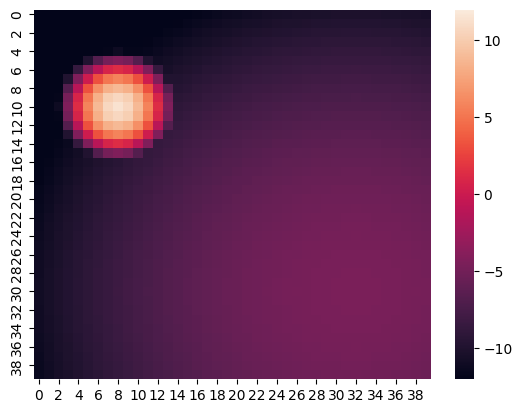

z = 8


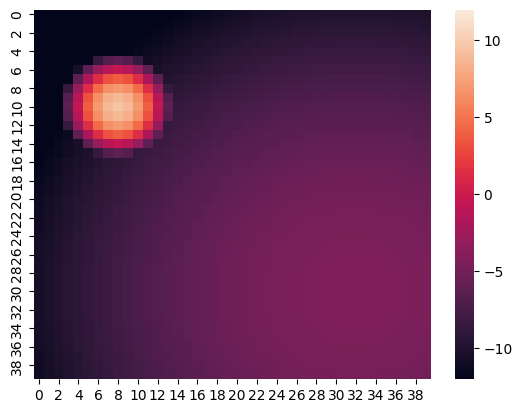

z = 9


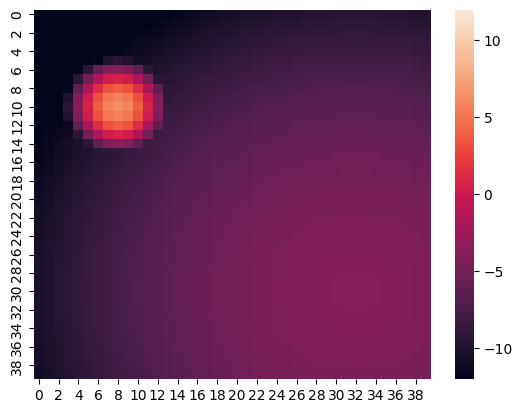

z = 10


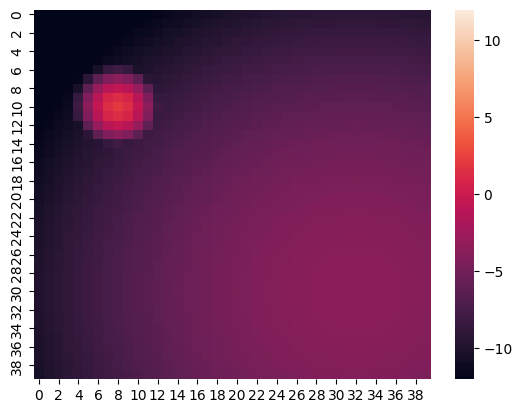

z = 11


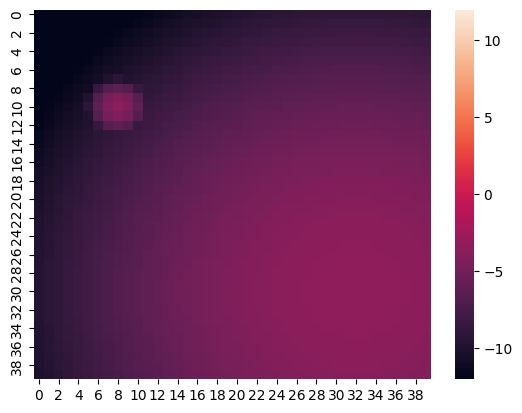

z = 12


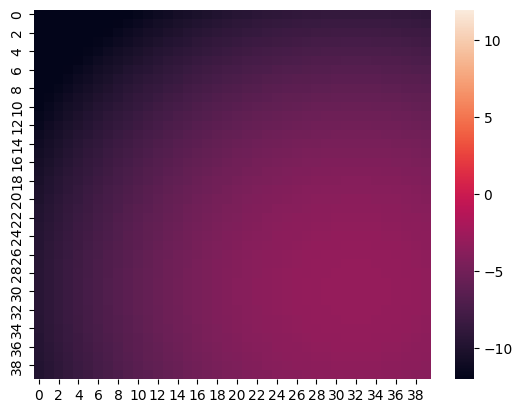

z = 13


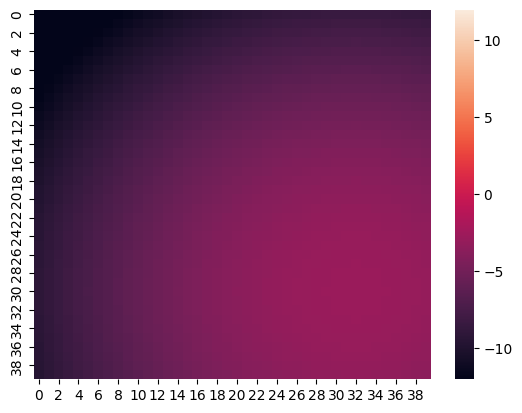

z = 14


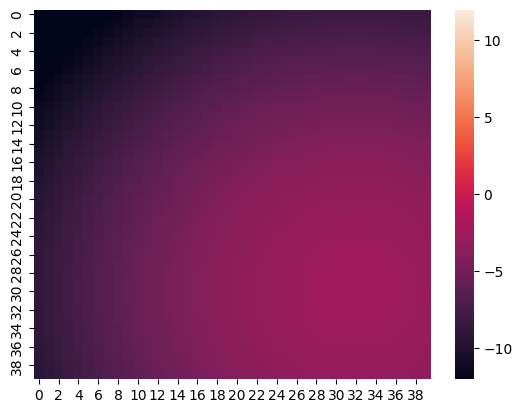

z = 15


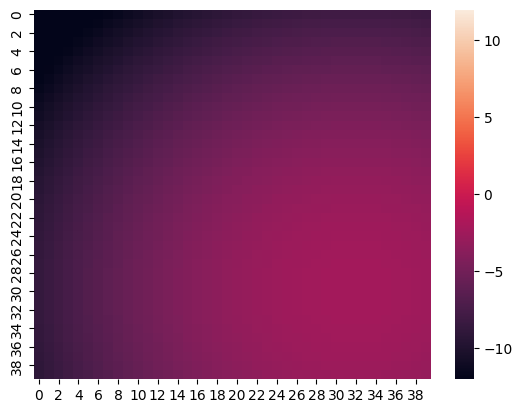

z = 16


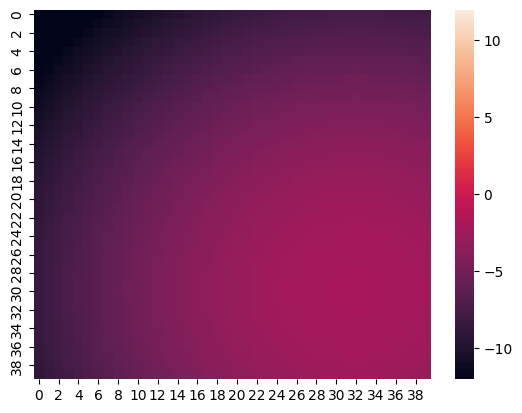

z = 17


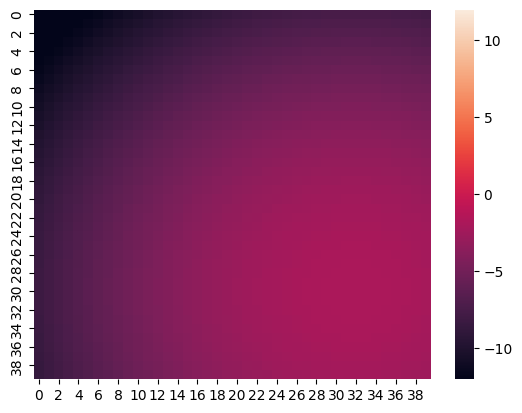

z = 18


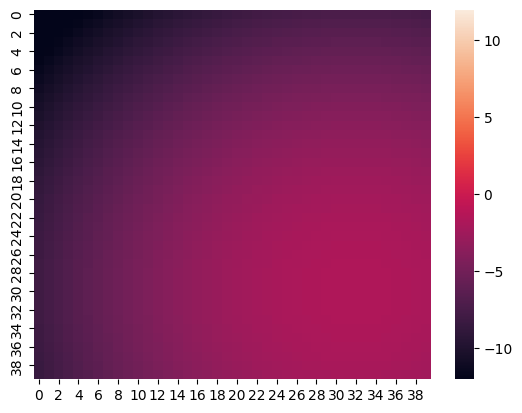

z = 19


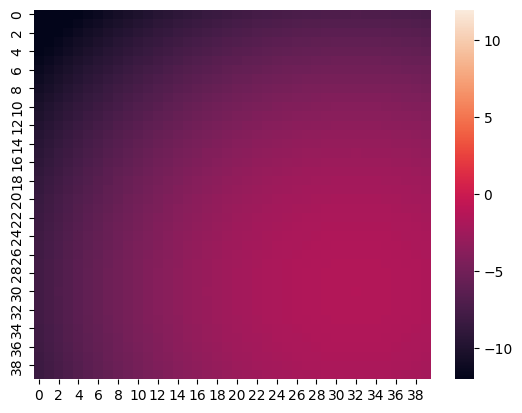

z = 20


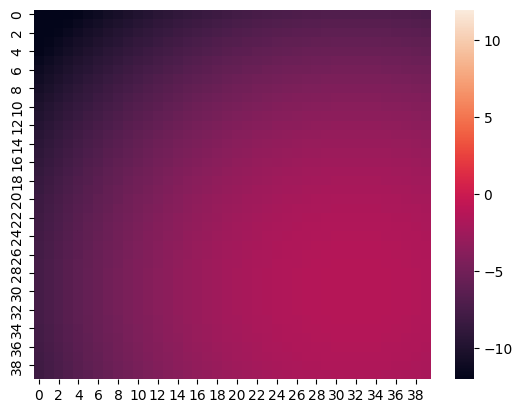

z = 21


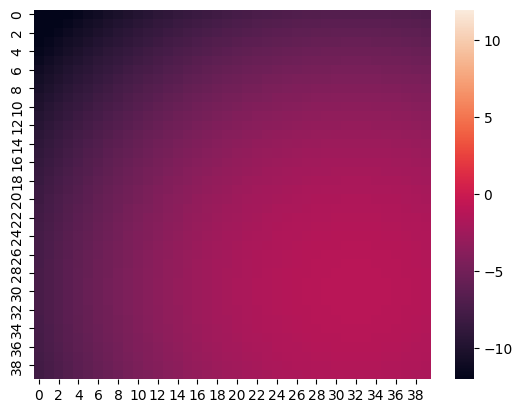

z = 22


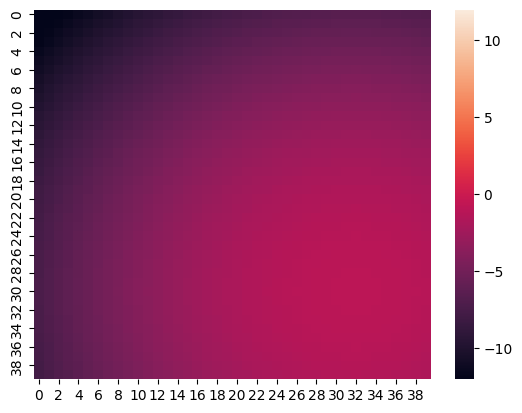

z = 23


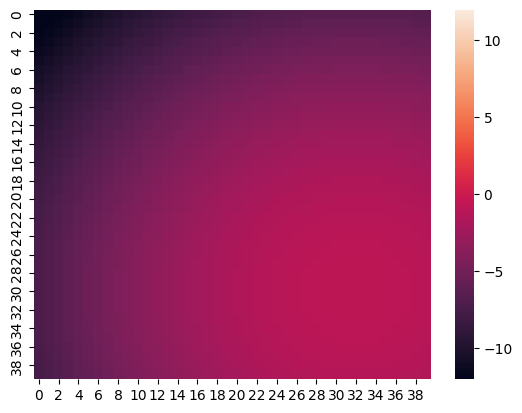

z = 24


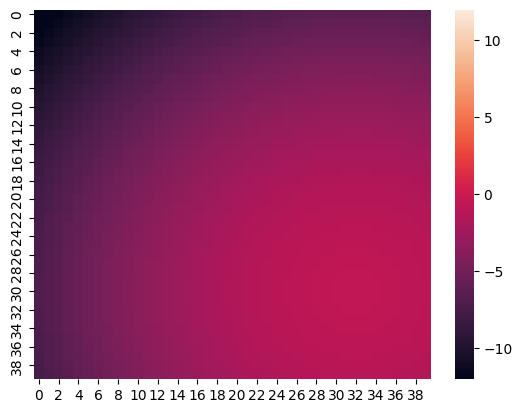

z = 25


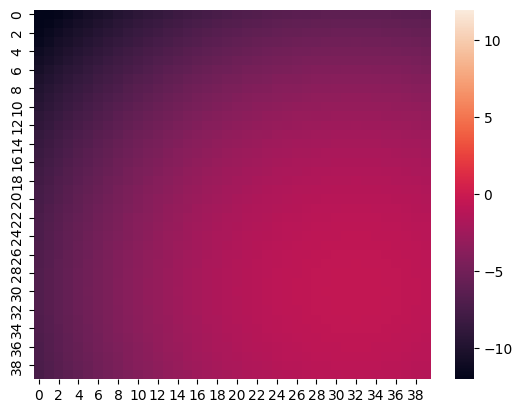

z = 26


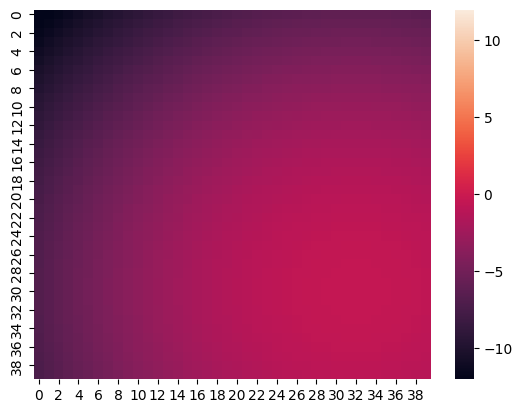

z = 27


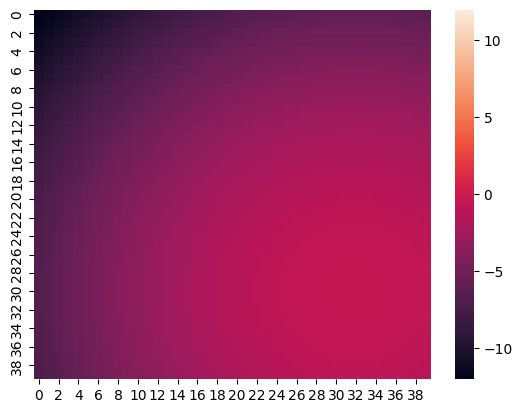

z = 28


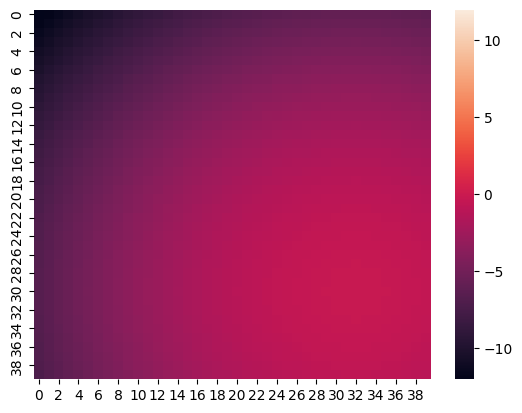

z = 29


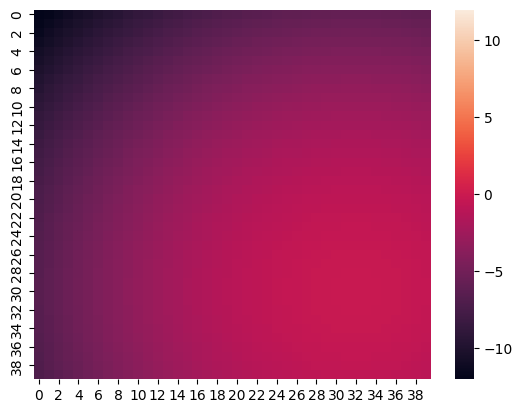

z = 30


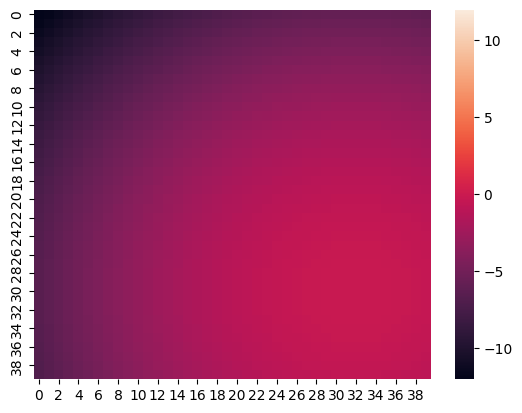

z = 31


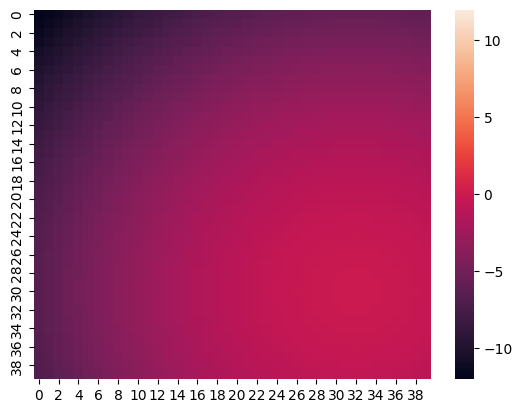

z = 32


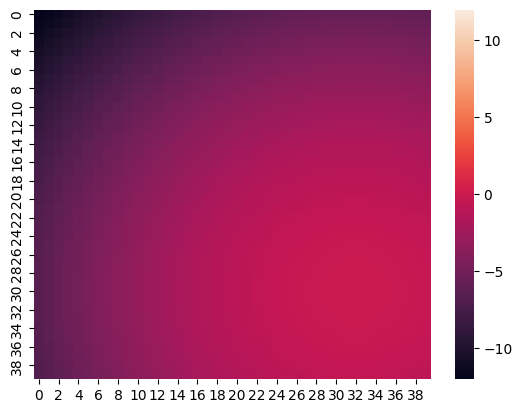

z = 33


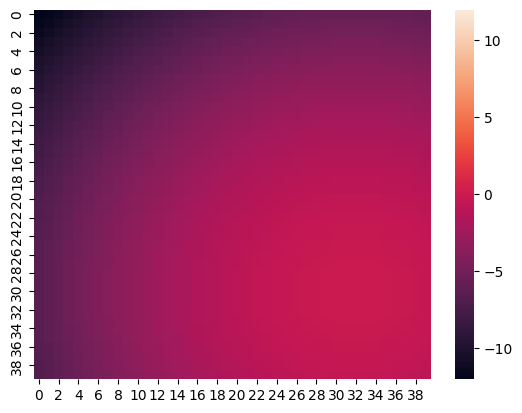

z = 34


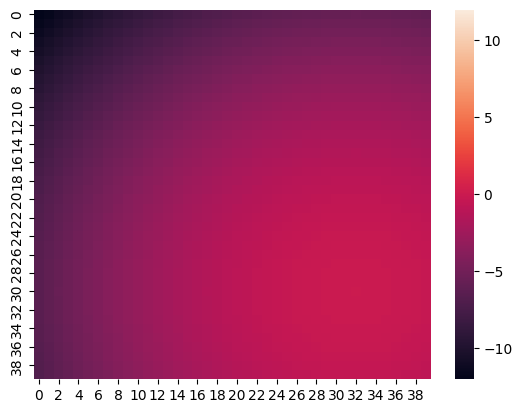

z = 35


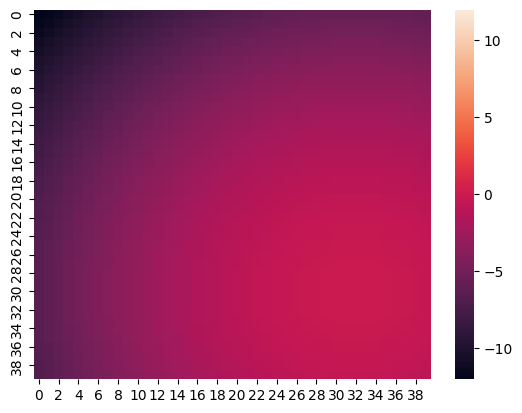

z = 36


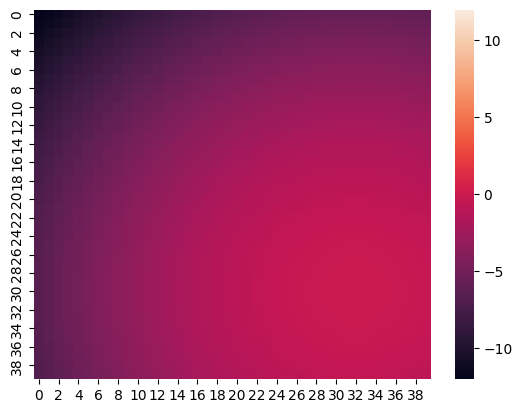

z = 37


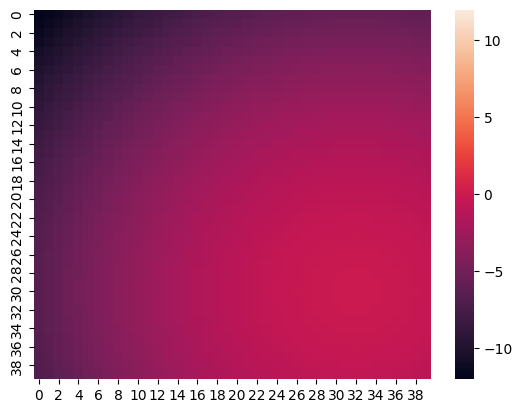

z = 38


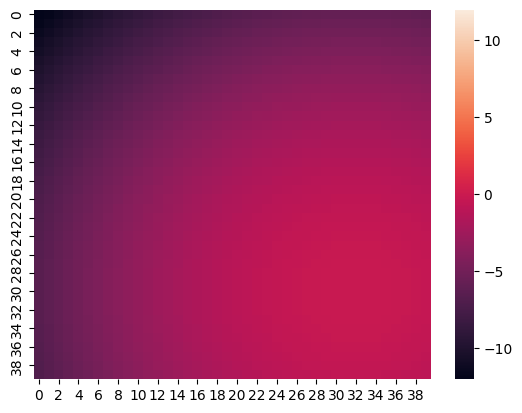

z = 39


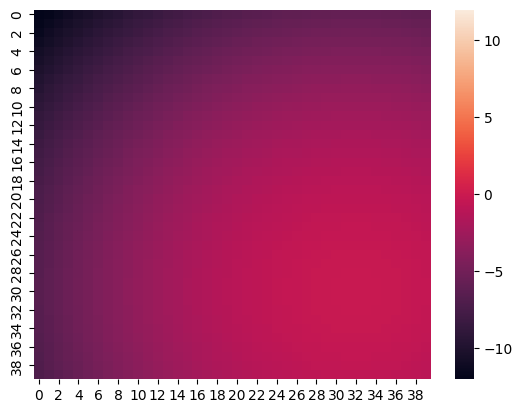

In [14]:
def plot_3D_rewards(env, reward_fn, n_maps=10):
    z_interval = int(env.state_dim / n_maps)
    for z in range(0, env.state_dim, z_interval):
        print("z =", z)
        sns.heatmap(reward_fn[:,:,z], vmin=-12, vmax=12)
        plt.show()
    
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=3, 
    optim_diff_coeff=10,
    suboptim_diff_coeff=0.1)

reward_fn = get_3D_reward_function(env)    

plot_3D_rewards(env, reward_fn, 40)

In [31]:
np.vstack(np.meshgrid(
        np.arange(0, 3),np.arange(0, 3),np.arange(0, 3))).reshape(3,-1)[2]

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2])

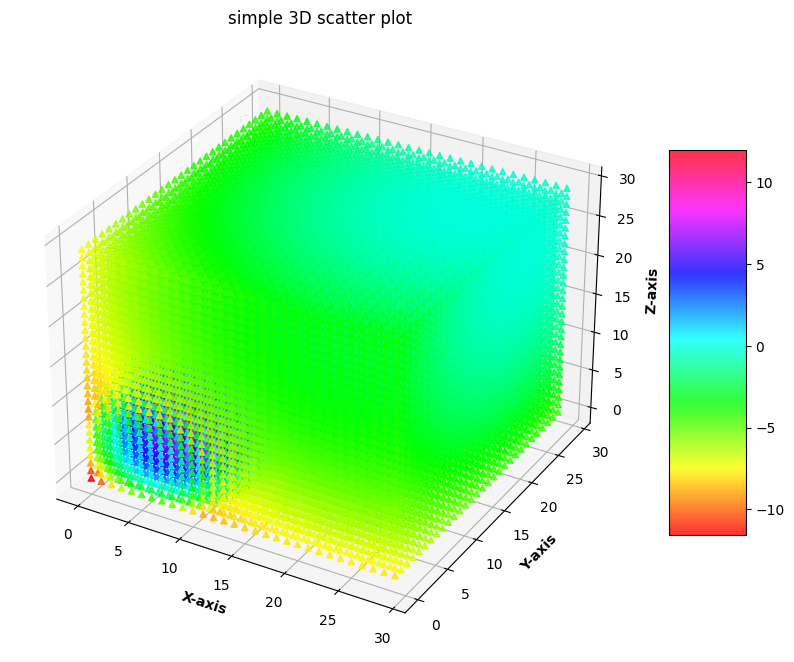

In [86]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def plot_3D_heatmap(reward_fn):
    m = np.vstack(np.meshgrid(
        np.arange(0, 30),np.arange(0, 30),np.arange(0, 30))).reshape(3,-1)
    x = m[0]
    y = m[1]
    z = m[2]
    colo = reward_fn.flatten()

    # creating figures
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # setting color bar
    my_cmap = plt.get_cmap('hsv')

    sctt = ax.scatter3D(x, y, z,
                        alpha = 0.8,
                        c = colo,
                        cmap = my_cmap,
                        marker ='^')

    plt.title("simple 3D scatter plot")
    ax.set_xlabel('X-axis', fontweight ='bold')
    ax.set_ylabel('Y-axis', fontweight ='bold')
    ax.set_zlabel('Z-axis', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

env = RelOvergenEnv(
    state_dim=30, 
    n_agents=3, 
    optim_diff_coeff=2,
    suboptim_diff_coeff=0.06)

reward_fn = get_3D_reward_function(env) 

plot_3D_heatmap(reward_fn)

## N-dim

In [54]:
def get_ND_reward_function(env):
    reward = np.zeros((env.state_dim,) * env.n_agents)
    with np.nditer(reward, flags=['multi_index'], op_flags=["readwrite"]) as it:
        for p in it:
            env.agents_pos = list(it.multi_index)
            p[...] = env.compute_reward()
    return reward

def compute_spike_ratio(env):
    reward_fn = get_ND_reward_function(env)
    size = reward_fn.flatten().shape[0]
    n_pos = np.sum(reward_fn > 0)
    ratio = (n_pos / size) * 100
    print("Ratio of positive reward positions is:", ratio)
    
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=3, 
    optim_diff_coeff=20)

compute_spike_ratio(env)

Ratio of positive reward positions is: 0.1921875


In [66]:
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=2, 
    optim_diff_coeff=1.5)

compute_spike_ratio(env)

Ratio of positive reward positions is: 22.9375


In [85]:
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=3, 
    optim_diff_coeff=2,
    suboptim_diff_coeff=0.06)

compute_spike_ratio(env)

Ratio of positive reward positions is: 5.5546875


In [87]:
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=4, 
    optim_diff_coeff=1,
    suboptim_diff_coeff=0.06)

compute_spike_ratio(env)

Ratio of positive reward positions is: 4.977265625


ATTENTION ça prend longtemps avec 5 agents

In [72]:
env = RelOvergenEnv(
    state_dim=40, 
    n_agents=5, 
    optim_diff_coeff=1)

compute_spike_ratio(env)

Ratio of positive reward positions is: 1.9717412109374999


# Plotting learnt Q-values

In [12]:
import torch

def get_q_tot(obs, model):
    init_last_actions, init_hidden_states = model.get_init_model_inputs()
    values = []
    for a_i in range(len(obs)):
        q_values, _ = model.agents[a_i].get_q_values(
            obs[a_i], 
            init_last_actions[a_i],
            init_hidden_states[a_i])
        values.append(float(q_values.max()))
    values = torch.Tensor(values).view(1, 1, -1)
    state = torch.cat(obs, dim=-1).unsqueeze(0)
    q_tot = model.mixer(values, state)
    return float(q_tot)

def get_q_function(model):
    value_fn = np.zeros((model.obs_dim, model.obs_dim))
    for i in range(model.obs_dim):
        for j in range(model.obs_dim):
            obs = [
                torch.Tensor([np.eye(model.obs_dim)[i]]),
                torch.Tensor([np.eye(model.obs_dim)[j]])
            ]
            value_fn[i, j] = get_q_tot(obs, model)
    return value_fn

/tmp/ipykernel_60071/965710976.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  torch.Tensor([np.eye(model.obs_dim)[i]]),


<AxesSubplot:>

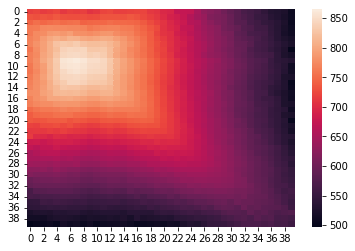

In [13]:
from model.modules.qmix import QMIX

model = QMIX.init_from_save("../../models/rel_overgen/qmix/run3/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

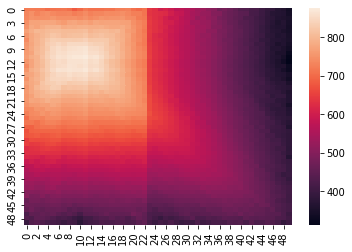

In [95]:
from model.modules.qmix_noveld import QMIX_MANovelD

model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run8/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

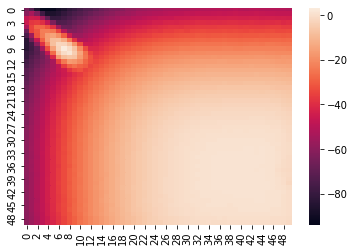

In [96]:
from model.modules.qmix import QMIX

model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run10/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

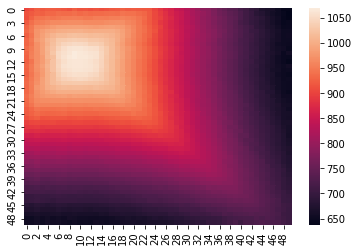

In [97]:
model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run6/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

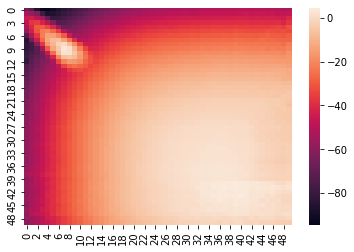

In [98]:
model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run5/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

# Plotting exploration of states

In [45]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_visit_map(run):
    vm = np.zeros((40,40))
    for s in run:
        vm[s[0], s[1]] += 1
    return vm

def get_visited_states(dir_path):
    vms = []
    for f in os.listdir(dir_path):
        if f[-5:] == ".json":
            print(f)
            with open(os.path.join(dir_path, f)) as f:
                vs = json.load(f)
            vms.append(np.log(get_visit_map(vs)))
    return vms

visited_states copy 8.json
visited_states copy 11.json
visited_states copy 6.json
visited_states copy 12.json
visited_states.json
visited_states copy 13.json
visited_states copy 4.json
visited_states copy.json
visited_states copy 2.json
visited_states copy 7.json
visited_states copy 14.json
visited_states copy 10.json
visited_states copy 5.json
visited_states copy 3.json
visited_states copy 9.json


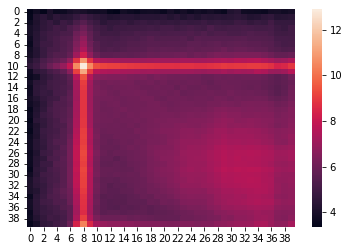

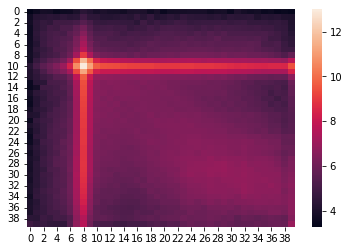

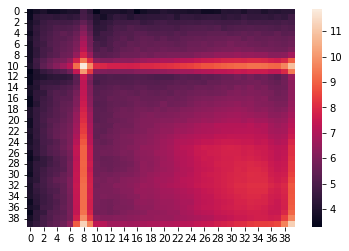

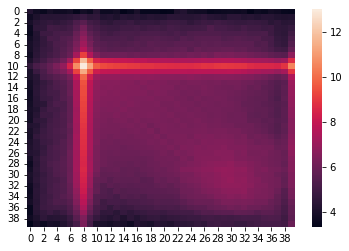

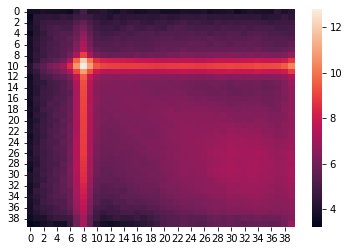

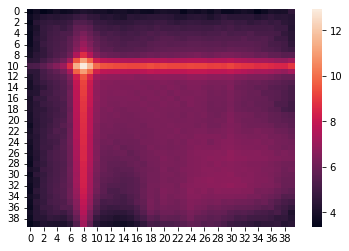

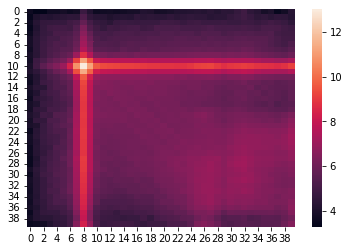

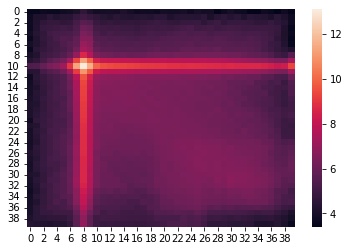

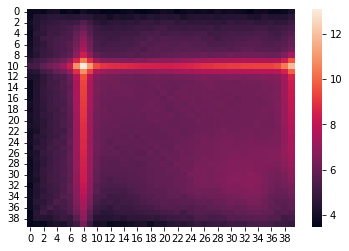

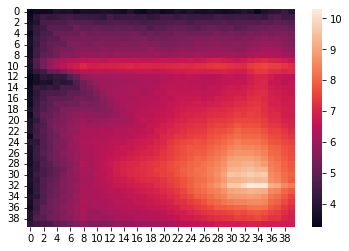

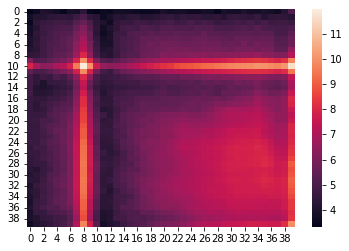

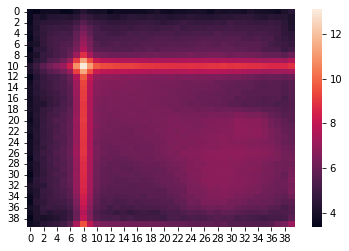

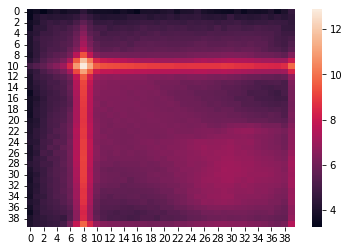

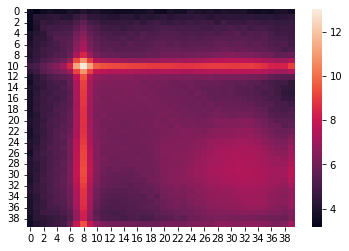

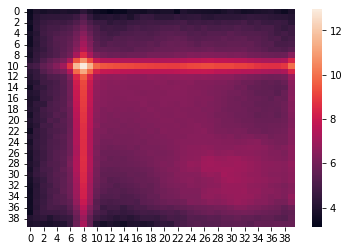

In [46]:
vms = get_visited_states("../../models/rel_overgen/qmix_cent_e2snoveld_inv_dyn/train_data_4030")

for vm in vms:
    sns.heatmap(vm)
    plt.show()

vs_run11.json
vs_run6.json
vs_run13.json
vs_run4.json
vs_run15.json
vs_run1.json
vs_run16.json
vs_run5.json
vs_run2.json
vs_run7.json
vs_run9.json
vs_run17.json
vs_run19.json
vs_run18.json
vs_run3.json


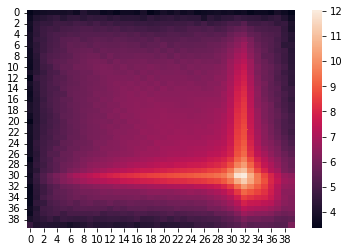

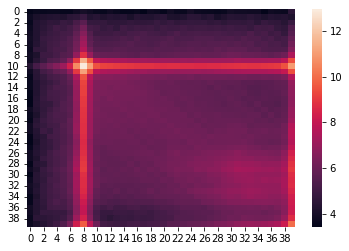

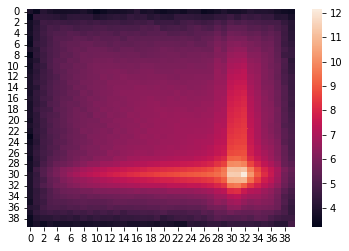

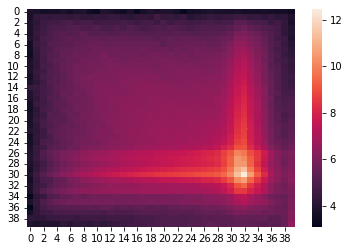

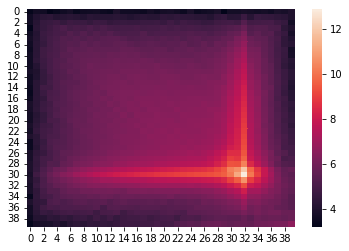

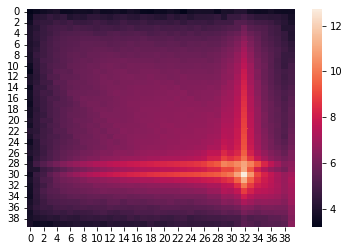

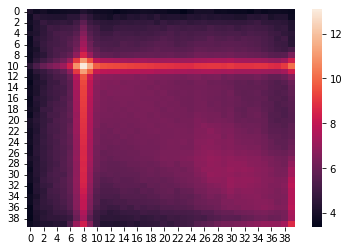

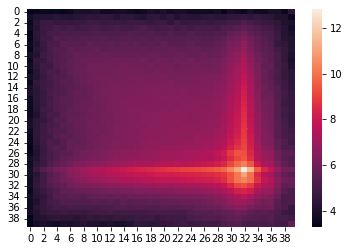

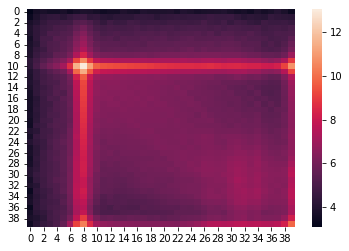

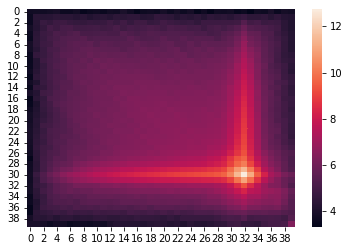

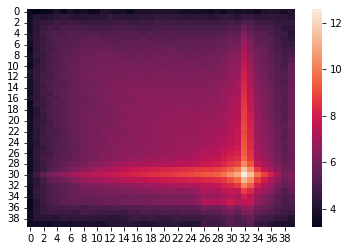

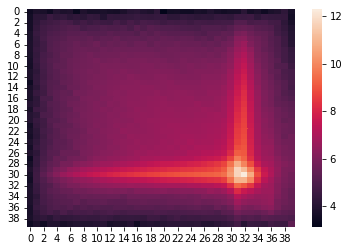

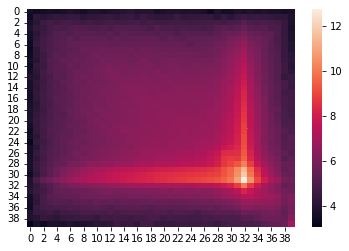

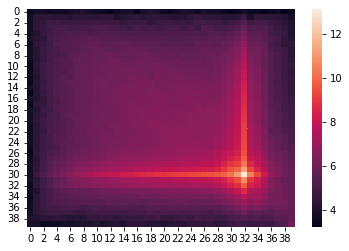

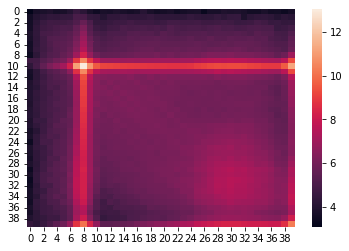

In [48]:
loc_vms = get_visited_states("../../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030")

for vm in loc_vms:
    sns.heatmap(vm)
    plt.show()

visited_states.json


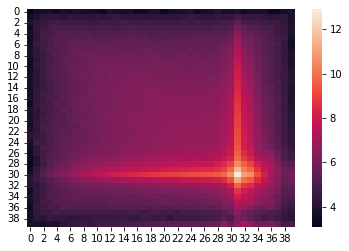

In [49]:
none_vms = get_visited_states("../../models/rel_overgen/qmix/train_data_40_30")

for vm in none_vms:
    sns.heatmap(vm)
    plt.show()

In [42]:
all_vms = np.array(vms)


(15, 40, 40)

<AxesSubplot:>

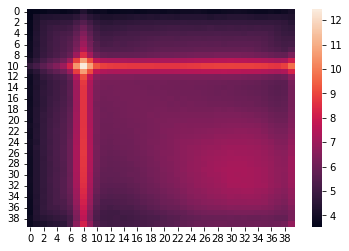

In [51]:
mean_vms = np.mean(vms, axis=0)
sns.heatmap(mean_vms)

In [31]:
from IPython import display

for i in range(40,100000,8000):
    vm = get_visit_map(vs[1][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()

IndexError: list index out of range

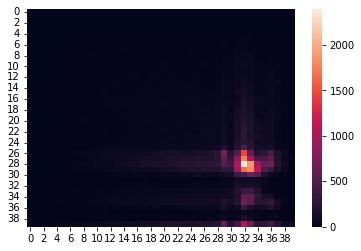

In [26]:
for i in range(40,100000,4000):
    vm = get_visit_map(vs_n[0][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()

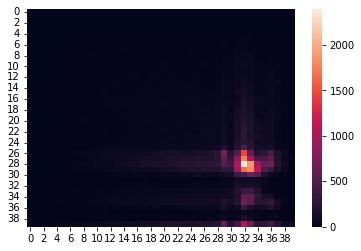

In [30]:
vs_l = get_visited_states("../../models/rel_overgen/qmix_loc_e2snoveld_inv_dyn/train_data_4030")
for i in range(40,100000,8000):
    vm = get_visit_map(vs_n[0][:i])
    display.clear_output(wait=True)
    sns.heatmap(vm)
    plt.show()